### Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from hyperopt import hp
from lib.similarity import CentroidSimilarity
from utils.hyper_parameters_tuning import model_hypopt
from sklearn.neighbors import KNeighborsClassifier
from lib.classifier_with_feature_selection import ClassifierFeatureSelection
from utils.experiment_utils import multiple_classifiers_fit_predict
from utils.experiment_utils import extract_features
from utils.experiment_utils import get_images_from_supervised_set
from sklearn.model_selection import train_test_split
from utils.visualization import bar_plot_scores
%load_ext autoreload
%autoreload 2

### Load the dataset

In [2]:
# define here a location for the downloaded dataset
datasets_dir = "c:/datasets/"
if os.path.isdir(datasets_dir) is not True:
    os.mkdir(datasets_dir)

In [3]:
ds_name = 'omniglot'
omniglot_ds, omniglot_ds_info = tfds.load(ds_name, split=['train', 'test'], shuffle_files=False, with_info=True, as_supervised=True,data_dir=datasets_dir)
print(omniglot_ds_info)

tfds.core.DatasetInfo(
    name='omniglot',
    full_name='omniglot/3.0.0',
    description="""
    Omniglot data set for one-shot learning. This dataset contains 1623 different
    handwritten characters from 50 different alphabets.
    """,
    homepage='https://github.com/brendenlake/omniglot/',
    data_path='c:/datasets/omniglot\\3.0.0',
    file_format=tfrecord,
    download_size=17.95 MiB,
    dataset_size=12.29 MiB,
    features=FeaturesDict({
        'alphabet': ClassLabel(shape=(), dtype=int64, num_classes=50),
        'alphabet_char_id': int64,
        'image': Image(shape=(105, 105, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=1623),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'small1': <SplitInfo num_examples=2720, num_shards=1>,
        'small2': <SplitInfo num_examples=3120, num_shards=1>,
        'test': <SplitInfo num_examples=13180, num_shards=1>,
        'train': <SplitInfo num_

In [4]:
label_set = list(range(1623))
train_images, train_labels = get_images_from_supervised_set(omniglot_ds[0], label_set, img_size=[105,105])
print(f"images shape = {train_images.shape}")
print(f"labels shape = {train_labels.shape}")

images shape = (19280, 105, 105, 3)
labels shape = (19280,)


In [5]:
# process the images - resize to the mnist size (28,28) and convert to gray scale
def preprocess_mnist_like(images):
    resized_images = tf.image.resize(images, size=[28,28], antialias=True).numpy()
    gray_images = np.expand_dims(np.dot(resized_images[...,:3], [0.2989, 0.5870, 0.1140]), axis=3)
    return gray_images

#processed_train_images = train_images
#print(f"processed images shape = {processed_train_images.shape}")

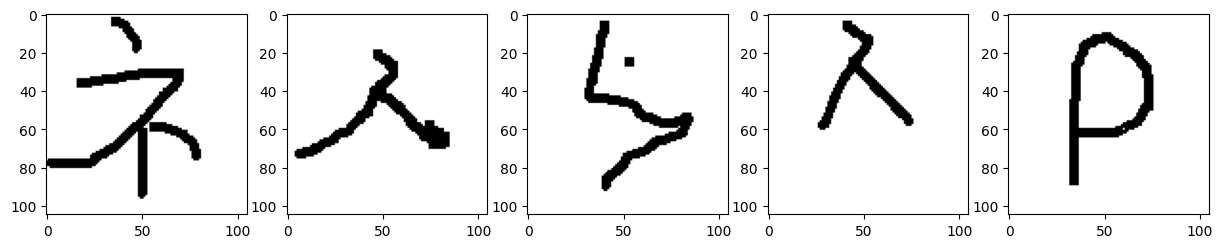

In [6]:
# plotting some examples from the data
fig, ax = plt.subplots(1,5,figsize=(15, 3))
for i in range(5):
    ax[i].imshow(train_images[i].numpy().astype("uint8"))

### Define a feature extractor

In [127]:
model = keras.models.load_model('c:/model_checkpoints/mnist_classification_convnet_date_25_3_23')
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 51, 51, 32)        2432      
                                                                 
 batch_normalization_28 (Bat  (None, 51, 51, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 11, 11, 32)        25632     
                                                                 
 batch_normalization_29 (Bat  (None, 11, 11, 32)       128       
 chNormalization)                                                
                                                     

In [128]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.get_layer(name="conv2d_29").output)

In [129]:
def preprocess(images):
    # convert from integers to floats and scale
    return images/255.0

In [130]:
batch_size = 32
with tf.device('/cpu:0'):
    train_ds = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)
X_train = extract_features(ds=train_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)

In [133]:
X_train = np.reshape(X_train,(X_train.shape[0],-1))
X_train.shape

(19280, 3872)

In [134]:
if tf.is_tensor(train_labels):
    y_train = train_labels.numpy()
else:
    y_train = train_labels
print(f"num of labels = {len(np.unique(y_train))}")


num of labels = 964


### Experiment 1 - scanning train set size

In [135]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']), #
                        'degree' : hp.choice('degree',list(range(1,10)))}
# sample a label set
num_classes = 10
label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
smpl_idx = []
for l in label_set:
    cls_idcs = np.squeeze(np.argwhere(y_train == l))
    smpl_idx.extend(list(cls_idcs))
svm_X_train, _, svm_y_train, _ = train_test_split(X_train[smpl_idx], y_train[smpl_idx], train_size=10*num_classes, stratify=y_train[smpl_idx])

# find hyper-parameters for the svm
hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=svm_X_train, y_train=svm_y_train, iterations=100)
svm_best_params = hyper_opt.run()
# tune a lasso classifier
lasso_search_space = {'C' : hp.uniform('C',0.001,10),
                          'penalty' : 'l1',
                          'solver' : 'liblinear'}
hyper_opt = model_hypopt(model=LogisticRegression, param_space=lasso_search_space, X_train=svm_X_train, y_train=svm_y_train, iterations=100)
lasso_best_params = hyper_opt.run()


100%|██████████| 100/100 [00:37<00:00,  2.68trial/s, best loss: -0.78]            


In [136]:
svm_best_params

{'C': 7.5657152103117955, 'degree': 6, 'kernel': 'rbf'}

Measuring accuracy with 10 classes,  5 training examples per class
---------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.1, std error is 0.0
classifier cs_fs_dp, mean accuracy is 0.1, std error is 0.0
classifier cs_fs_ova, mean accuracy is 0.1, std error is 0.0
classifier svm, mean accuracy is 0.83, std error is 0.01
classifier lasso, mean accuracy is 0.74, std error is 0.01



classifier cs_cls, mean num features is 3872.0, std error is 0.0
classifier cs_fs_dp, mean num features is 590.0, std error is 4.0
classifier cs_fs_ova, mean num features is 2147.0, std error is 29.0
classifier svm, mean num features is 3872.0, std error is 0.0
classifier lasso, mean num features is 512.0, std error is 6.0




Measuring accuracy with 10 classes,  10 training examples per class
---------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.1, std error is 0.0
classifier cs_fs_dp, mean accuracy is 0.1, std error

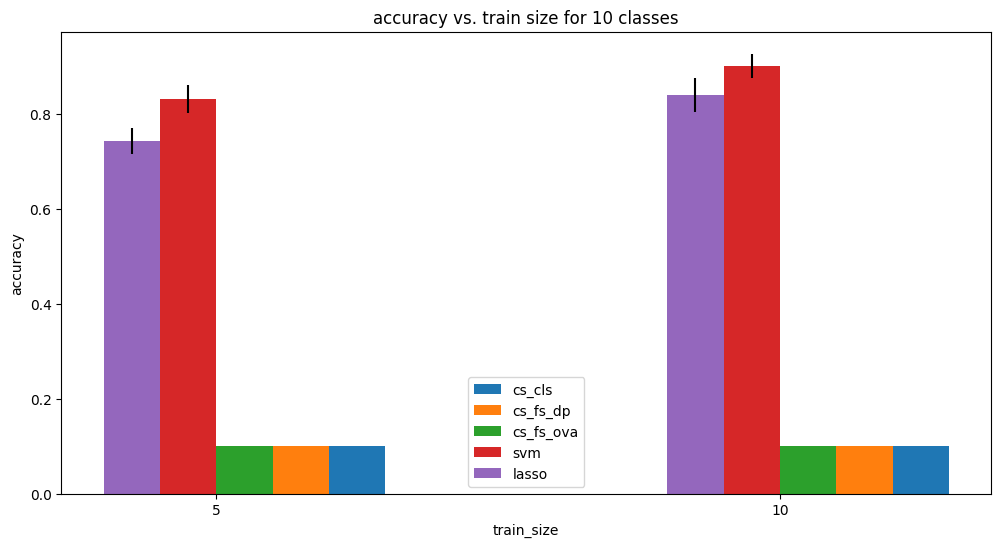

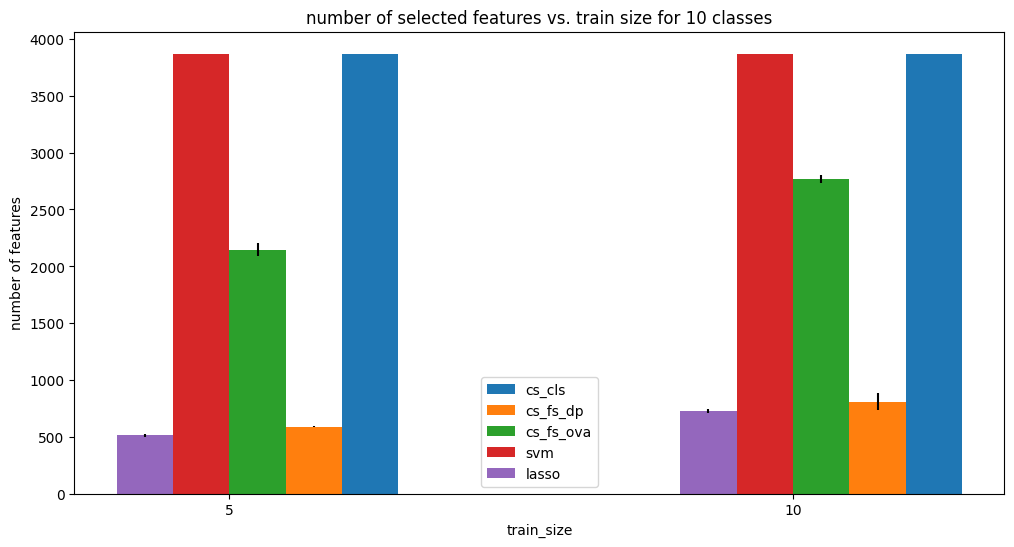

In [137]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.2
# define possible sizes for the train set (number of train examples per class)
train_sizes = [5,10]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=5000)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(CentroidSimilarity(), dp_fs)
#cs_fs_dp_perm = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
cs_fs_ova = ClassifierFeatureSelection(CentroidSimilarity(), ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**svm_best_params)
#svm_cls = SVC(kernel='linear', degree=1)
lasso_cls = LogisticRegression(**lasso_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, svm_cls, lasso_cls]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'svm', 'lasso']
num_experiments = 10
num_splits = 3
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

# generate a set of label sets - this way we can keep the labels fixed when we modify the train size
label_sets = []
for j in range(num_experiments):
    # sample a label set
    label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
    label_sets.append(label_set)

for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        label_set = label_sets[j]
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(cls_idcs))

        smpl_X = X_train[smpl_idx]
        smpl_y = y_train[smpl_idx]
        # calculate accuracy and get the number of features over few splits
        split_accuracies = np.empty((len(classifiers), num_splits))
        split_num_features = np.empty((len(classifiers), num_splits))
        for k in range(num_splits):
            smpl_X_train, smpl_X_test, smpl_y_train, smpl_y_test = train_test_split(smpl_X, smpl_y, train_size=train_sizes[i]*num_classes, stratify=smpl_y)
            split_accuracies[:-1,k], split_num_features[:-1,k] = multiple_classifiers_fit_predict(classifiers=classifiers[:-1],
                                                                                              X_train=smpl_X_train,
                                                                                              y_train=smpl_y_train,
                                                                                              X_test=smpl_X_test,
                                                                                              y_test=smpl_y_test)
            lasso_cls.fit(smpl_X_train, smpl_y_train)
            split_accuracies[-1,k] = lasso_cls.score(smpl_X_test, smpl_y_test)
            lasso_features = []
            for v in range(lasso_cls.coef_.shape[0]):
                lasso_features.extend(list(np.flatnonzero(lasso_cls.coef_[v,:])))
            lasso_features = set(lasso_features)
            lasso_num_coeff = len(lasso_features)
            split_num_features[-1,k] = lasso_num_coeff
        accuracies[:,i,j] = np.mean(split_accuracies, axis=1)
        num_features[:,i,j] = np.mean(split_num_features, axis=1)

    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.round(np.mean(accuracies[l,i,:]),2)}, std error is {np.round(np.std(accuracies[l,i,:])/np.sqrt(accuracies.shape[2]),2)}")
    print("\n\n")
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean num features is {np.round(np.mean(num_features[l,i,:]),0)}, std error is {np.round(np.std(num_features[l,i,:])/np.sqrt(num_features.shape[2]),0)}")
    print("\n\n\n")

bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes',
                err=2*np.std(accuracies,axis=2)/np.sqrt(accuracies.shape[2]))

bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes',
                err=2*np.std(num_features,axis=2)/np.sqrt(num_features.shape[2]))

### Experiment 2 -  Classification of noisy images

In [121]:
threshold = 0.35
noise = np.random.rand(*train_images.numpy().shape[0:3])
mask = noise < threshold
mask = np.repeat(np.expand_dims(mask,axis=3), repeats=3, axis=3)


In [122]:
noisy_images = train_images.numpy()//255
noisy_images = np.logical_xor(noisy_images,mask)
noisy_images = noisy_images * 255.0

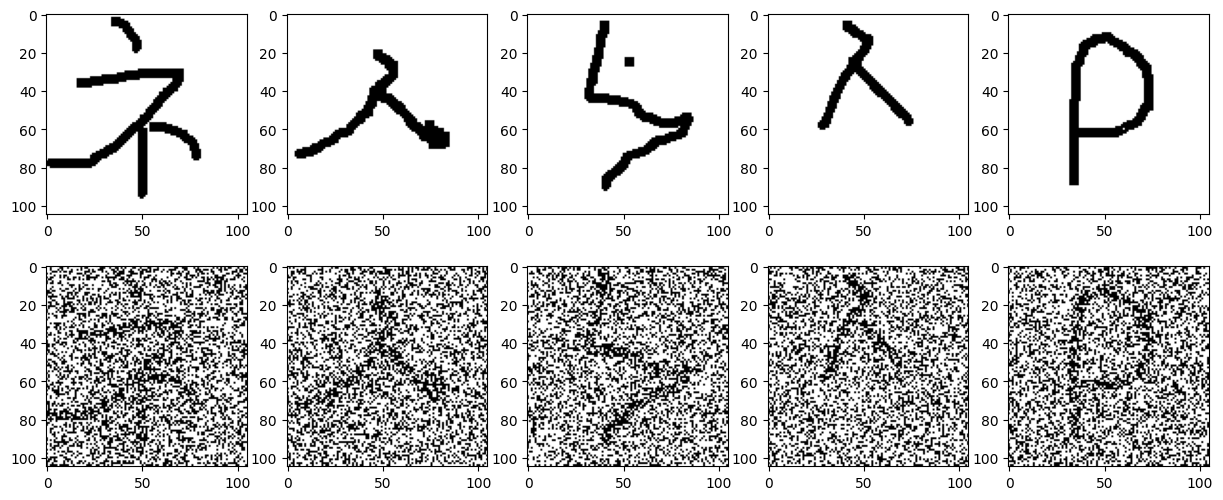

In [123]:
fig, ax = plt.subplots(2,5,figsize=(15, 6))
for i in range(5):
    ax[0,i].imshow(train_images[i].numpy().astype("uint8"))
    ax[1,i].imshow(noisy_images[i].astype("uint8"))


In [124]:
batch_size = 32
with tf.device('/cpu:0'):
    noisy_train_ds = tf.data.Dataset.from_tensor_slices(noisy_images).batch(batch_size)
X_noisy = extract_features(ds=noisy_train_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)

In [125]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
# sample a label set
num_classes = 10
label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
smpl_idx = []
for l in label_set:
    cls_idcs = np.squeeze(np.argwhere(y_train == l))
    smpl_idx.extend(list(cls_idcs))
svm_X_train, _, svm_y_train, _ = train_test_split(X_noisy[smpl_idx], y_train[smpl_idx], train_size=10*num_classes, stratify=y_train[smpl_idx])
# find hyper-parameters for the svm
hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=svm_X_train, y_train=svm_y_train, iterations=100)
svm_best_params = hyper_opt.run()
# tune a lasso classifier
lasso_search_space = {'C' : hp.uniform('C',0.001,10),
                          'penalty' : 'l1',
                          'solver' : 'liblinear'}
hyper_opt = model_hypopt(model=LogisticRegression, param_space=lasso_search_space, X_train=svm_X_train, y_train=svm_y_train, iterations=100)
lasso_best_params = hyper_opt.run()


100%|██████████| 100/100 [00:35<00:00,  2.80trial/s, best loss: -0.26]              


In [97]:
svm_best_params

{'C': 5.749782388075122, 'degree': 6, 'kernel': 'rbf'}

In [126]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.2
# define possible sizes for the train set (number of train examples per class)
train_sizes = [5,10]
num_experiments = 50
num_splits = 5
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=5000)
# defining classifiers
use_euclidian_distance = False
cs_cls  = CentroidSimilarity(use_euclidian_distance=use_euclidian_distance)
cs_fs_dp = ClassifierFeatureSelection(CentroidSimilarity(use_euclidian_distance=use_euclidian_distance), dp_fs)
#cs_fs_dp_perm = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
cs_fs_ova = ClassifierFeatureSelection(CentroidSimilarity(use_euclidian_distance=use_euclidian_distance), ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(KNeighborsClassifier(n_neighbors=train_sizes[0]), dp_fs)
knn_fs_ova = ClassifierFeatureSelection(KNeighborsClassifier(n_neighbors=train_sizes[0]), ova_fs)
svm_cls = SVC(**svm_best_params)
lasso_cls = LogisticRegression(**lasso_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, svm_cls, lasso_cls]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'svm', 'lasso']
# init arrays to hold the accuracies
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))

# generate a set of label sets - this way we can keep the labels fixed when we modify the train size
label_sets = []
for j in range(num_experiments):
    # sample a label set
    label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
    label_sets.append(label_set)

# run the experiment
for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        label_set = label_sets[j]
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(cls_idcs))

        smpl_X = X_noisy[smpl_idx]
        smpl_y = y_train[smpl_idx]
        # calculate accuracy and get the number of features over few splits
        split_accuracies = np.empty((len(classifiers), num_splits))
        split_num_features = np.empty((len(classifiers), num_splits))
        for k in range(num_splits):
            smpl_X_train, smpl_X_test, smpl_y_train, smpl_y_test = train_test_split(smpl_X, smpl_y, train_size=train_sizes[i]*num_classes, stratify=smpl_y)
            split_accuracies[:-1,k], split_num_features[:-1,k] = multiple_classifiers_fit_predict(classifiers=classifiers[:-1],
                                                                                              X_train=smpl_X_train,
                                                                                              y_train=smpl_y_train,
                                                                                              X_test=smpl_X_test,
                                                                                              y_test=smpl_y_test)
            lasso_cls.fit(smpl_X_train, smpl_y_train)
            split_accuracies[-1,k] = lasso_cls.score(smpl_X_test, smpl_y_test)
            lasso_features = []
            for v in range(lasso_cls.coef_.shape[0]):
                lasso_features.extend(list(np.flatnonzero(lasso_cls.coef_[v,:])))
            lasso_features = set(lasso_features)
            lasso_num_coeff = len(lasso_features)
            split_num_features[-1,k] = lasso_num_coeff
        accuracies[:,i,j] = np.mean(split_accuracies, axis=1)
        num_features[:,i,j] = np.mean(split_num_features, axis=1)
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.round(np.mean(accuracies[l,i,:]),2)}, std error is {np.round(np.std(accuracies[l,i,:])/np.sqrt(accuracies.shape[2]),2)}")
    print("\n\n")
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean num features is {np.round(np.mean(num_features[l,i,:]),0)}, std error is {np.round(np.std(num_features[l,i,:])/np.sqrt(num_features.shape[2]),0)}")
    print("\n\n\n")


bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes',
                err=2*np.std(accuracies,axis=2)/np.sqrt(accuracies.shape[2]))

bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes',
                err=2*np.std(num_features,axis=2)/np.sqrt(num_features.shape[2]))

Measuring accuracy with 10 classes,  5 training examples per class
---------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.1, std error is 0.0
classifier cs_fs_dp, mean accuracy is 0.22, std error is 0.01
classifier cs_fs_ova, mean accuracy is 0.11, std error is 0.0
classifier svm, mean accuracy is 0.29, std error is 0.01
classifier lasso, mean accuracy is 0.18, std error is 0.0



classifier cs_cls, mean num features is 512.0, std error is 0.0
classifier cs_fs_dp, mean num features is 58.0, std error is 1.0
classifier cs_fs_ova, mean num features is 211.0, std error is 3.0
classifier svm, mean num features is 512.0, std error is 0.0
classifier lasso, mean num features is 45.0, std error is 0.0




Measuring accuracy with 10 classes,  10 training examples per class
---------------------------------------------------------------


KeyboardInterrupt: 

### Experiment 3 - add noise to the extracted features

In [73]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
# sample a label set
num_classes = 10
noise_std = 2

label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
smpl_idx = []
for l in label_set:
    cls_idcs = np.squeeze(np.argwhere(y_train == l))
    smpl_idx.extend(list(cls_idcs))
svm_X_train, _, svm_y_train, _ = train_test_split(X_train[smpl_idx] + np.random.randn(*X_train[smpl_idx].shape)*noise_std,
                                                  y_train[smpl_idx],
                                                  train_size=10*num_classes,
                                                  stratify=y_train[smpl_idx])
# find hyper-parameters for the svm
hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=svm_X_train, y_train=svm_y_train, iterations=100)
svm_best_params = hyper_opt.run()
# tune a lasso classifier
lasso_search_space = {'C' : hp.uniform('C',0.001,10),
                          'penalty' : 'l1',
                          'solver' : 'liblinear'}
hyper_opt = model_hypopt(model=LogisticRegression, param_space=lasso_search_space, X_train=svm_X_train, y_train=svm_y_train, iterations=100)
lasso_best_params = hyper_opt.run()


100%|██████████| 100/100 [00:20<00:00,  4.99trial/s, best loss: -0.62]             


Measuring accuracy with 10 classes,  5 training examples per class
---------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.68, std error is 0.01
classifier cs_fs_dp, mean accuracy is 0.63, std error is 0.01
classifier cs_fs_ova, mean accuracy is 0.7, std error is 0.01
classifier svm, mean accuracy is 0.72, std error is 0.01
classifier lasso, mean accuracy is 0.46, std error is 0.01



classifier cs_cls, mean num features is 800.0, std error is 0.0
classifier cs_fs_dp, mean num features is 150.0, std error is 1.0
classifier cs_fs_ova, mean num features is 567.0, std error is 3.0
classifier svm, mean num features is 800.0, std error is 0.0
classifier lasso, mean num features is 228.0, std error is 1.0




Measuring accuracy with 10 classes,  10 training examples per class
---------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.61, std error is 0.01
classifier cs_fs_dp, mean accuracy is 0.76, std e

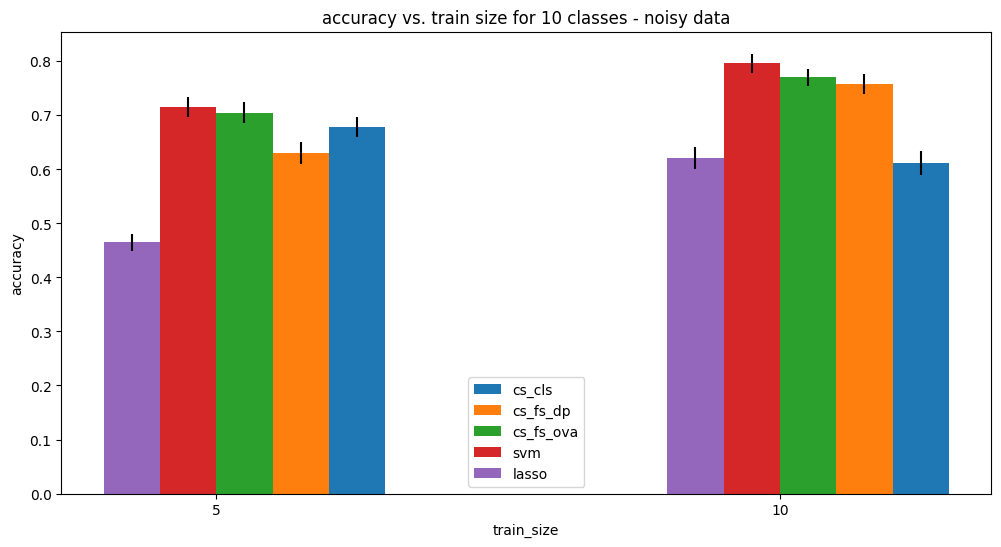

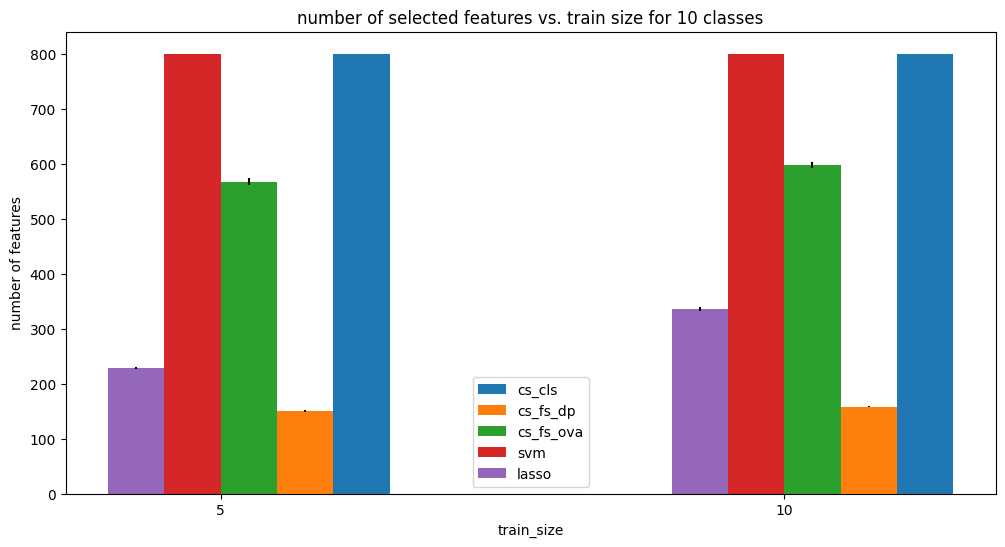

In [74]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
from lib.feature_selection import FeatureSelectionDiversityPursuitKruskal
gamma = 0.2
train_sizes = [5,10]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=5000)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(CentroidSimilarity(), dp_fs)
#cs_fs_dp_perm = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
cs_fs_ova = ClassifierFeatureSelection(CentroidSimilarity(), ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**svm_best_params)
lasso_cls = LogisticRegression(**lasso_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, svm_cls, lasso_cls]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'svm', 'lasso']
num_experiments = 50
num_splits = 5
# define possible sizes for the train set (number of train examples per class)
num_classes = 10
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

# generate a set of label sets - this way we can keep the labels fixed when we modify the train size
label_sets = []
for j in range(num_experiments):
    # sample a label set
    label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
    label_sets.append(label_set)

for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = label_sets[j]
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(cls_idcs))

        smpl_X = X_train[smpl_idx]
        smpl_y = y_train[smpl_idx]
        # calculate accuracy and get the number of features over few splits
        split_accuracies = np.empty((len(classifiers), num_splits))
        split_num_features = np.empty((len(classifiers), num_splits))
        split_accuracies_w_noise = np.empty((len(classifiers), num_splits))
        split_num_features_w_noise = np.empty((len(classifiers), num_splits))
        for k in range(num_splits):
            smpl_X_train, smpl_X_test, smpl_y_train, smpl_y_test = train_test_split(smpl_X, smpl_y, train_size=train_sizes[i]*num_classes, stratify=smpl_y)
            noisy_smpl_X_train = smpl_X_train + np.random.randn(*smpl_X_train.shape)*noise_std
            noisy_smpl_X_test = smpl_X_test + np.random.randn(*smpl_X_test.shape)*noise_std
            split_accuracies_w_noise[:-1,k], split_num_features_w_noise[:-1,k] = multiple_classifiers_fit_predict(classifiers=classifiers[:-1],
                                                                                              X_train=noisy_smpl_X_train,
                                                                                              y_train=smpl_y_train,
                                                                                              X_test=noisy_smpl_X_test,
                                                                                              y_test=smpl_y_test)
            lasso_cls.fit(noisy_smpl_X_train, smpl_y_train)
            split_accuracies_w_noise[-1,k] = lasso_cls.score(noisy_smpl_X_test, smpl_y_test)
            lasso_features = []
            for v in range(lasso_cls.coef_.shape[0]):
                lasso_features.extend(list(np.flatnonzero(lasso_cls.coef_[v,:])))
            lasso_features = set(lasso_features)
            lasso_num_coeff = len(lasso_features)
            split_num_features_w_noise[-1,k] = lasso_num_coeff



        accuracies_w_noise[:,i,j] = np.mean(split_accuracies_w_noise, axis=1)
        num_features_w_noise[:,i,j] = np.mean(split_num_features_w_noise, axis=1)

    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.round(np.mean(accuracies_w_noise[l,i,:]),2)}, "
              f"std error is {np.round(np.std(accuracies_w_noise[l,i,:])/np.sqrt(accuracies.shape[2]),2)}")
    print("\n\n")
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean num features is {np.round(np.mean(num_features_w_noise[l,i,:]),0)}, "
              f"std error is {np.round(np.std(num_features_w_noise[l,i,:])/np.sqrt(num_features.shape[2]),0)}")
    print("\n\n\n")


bar_plot_scores(scores=np.mean(accuracies_w_noise,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes - noisy data',
                err=2*np.std(accuracies_w_noise,axis=2)/np.sqrt(accuracies_w_noise.shape[2]))

bar_plot_scores(scores=np.mean(num_features_w_noise,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes',
                err=2*np.std(num_features_w_noise,axis=2)/np.sqrt(num_features_w_noise.shape[2]))

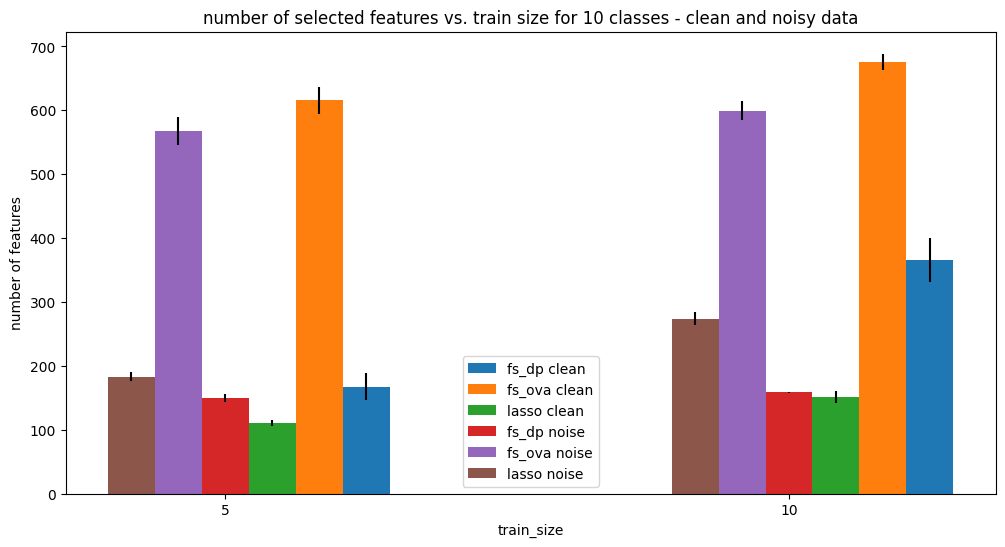

In [26]:
# show the number of features from the clean and the noisy data side by side
num_features_agg = np.concatenate((num_features[[1,2,4],:,:], num_features_w_noise[[1,2,4],:,:]), axis=0)
bar_plot_scores(scores=np.mean(num_features_agg,axis=2),
                bar_labels=['fs_dp clean', 'fs_ova clean', 'lasso clean','fs_dp noise', 'fs_ova noise', 'lasso noise'],
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes - clean and noisy data',
                err=np.std(num_features_agg,axis=2))